# Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from tqdm import tqdm
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Read the training and testing data


In [3]:
train_df = pd.read_csv("/kaggle/input/kaust-vs-kku-tournament-round-4/train.csv")
test_df = pd.read_csv("/kaggle/input/kaust-vs-kku-tournament-round-4/test.csv")

In [4]:
train_df['Datetime'] = pd.to_datetime(train_df['Datetime'])
test_df['Datetime'] = pd.to_datetime(test_df['Datetime'])  # added this line

In [5]:
train_df

,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,2021-11-08 19:03:09,37.18,33.37,24.3,80.0,0
1,2021-11-08 18:18:15,24.12,15.57,25.0,75.0,1
2,2021-10-16 14:19:36,26.50,17.17,29.3,62.0,1
3,2021-11-09 09:10:58,12.27,8.72,25.2,75.0,1
4,2021-10-23 19:41:02,31.68,31.80,25.2,75.0,0
...,...,...,...,...,...,...
141533,2021-10-29 23:20:18,41.45,30.03,21.0,92.0,1
141534,2021-11-27 18:19:57,6.05,4.23,25.2,67.0,1
141535,2021-11-04 20:16:16,71.95,69.23,21.6,88.0,0
141536,2021-11-24 19:53:25,49.77,57.43,25.5,69.0,0


In [6]:
test_df

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
0,0,2021-12-01 05:46:00,35.43,25.67,20.8,91.0
1,1,2022-01-10 01:07:00,50.98,43.77,20.2,91.0
2,2,2021-12-05 05:46:00,18.55,13.32,18.8,96.0
3,3,2022-01-05 03:06:00,119.60,104.38,18.3,84.0
4,4,2022-01-06 06:05:00,138.32,116.70,18.6,84.0
...,...,...,...,...,...,...
155634,155634,2022-01-01 20:01:00,13.30,10.43,21.5,81.0
155635,155635,2022-01-02 13:50:00,4.60,3.55,28.6,65.0
155636,155636,2021-12-03 03:51:00,28.15,30.47,23.0,86.0
155637,155637,2021-12-15 16:34:00,29.42,24.02,25.9,65.0


In [7]:
def extract_datetime_features(df):
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df['Year'] = df['Datetime'].dt.year
    df['Hour'] = df['Datetime'].dt.hour
    df['IsNight'] = df['Hour'].between(0, 6).astype(int)
    df['PM2.5_diff'] = (df['Sensor1_PM2.5'] - df['Sensor2_PM2.5']).abs()
    df = df.drop(columns=['Datetime'])  # remove timestamp
    return df

In [8]:
train_df['Datetime'] = pd.to_datetime(train_df['Datetime'])
train_df = train_df.sort_values('Datetime').reset_index(drop=True)

In [9]:
train_df = extract_datetime_features(train_df)
test_df  = extract_datetime_features(test_df)

In [10]:
train_df

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,Year,Hour,IsNight,PM2.5_diff
0,9.17,9.28,29.9,53.0,0,2021,16,0,0.11
1,9.93,11.25,29.9,53.0,0,2021,16,0,1.32
2,6.53,3.15,29.9,53.0,1,2021,16,0,3.38
3,8.30,8.35,29.9,53.0,0,2021,16,0,0.05
4,6.87,9.57,29.9,53.0,0,2021,16,0,2.70
...,...,...,...,...,...,...,...,...,...
141533,30.38,22.10,20.9,87.0,1,2021,23,0,8.28
141534,38.78,36.78,20.9,87.0,0,2021,23,0,2.00
141535,34.25,39.07,20.9,87.0,0,2021,23,0,4.82
141536,25.13,19.30,20.9,87.0,1,2021,23,0,5.83


In [11]:
ID = test_df['ID']  # We will use this later in preparing the submission file, but we don't need it in making predictions
test_df.drop('ID',inplace=True,axis=1)

In [12]:
train_df.isnull().sum()

Sensor1_PM2.5        3614
Sensor2_PM2.5        3614
Temperature          1040
Relative_Humidity    1040
Offset_fault            0
Year                    0
Hour                    0
IsNight                 0
PM2.5_diff           3614
dtype: int64

In [13]:
pip install tqdm tqdm-joblib

Note: you may need to restart the kernel to use updated packages.


In [14]:
# Fill missing values in train and test with column-wise mean
train_df = train_df.fillna(train_df.mean())
test_df = test_df.fillna(test_df.mean())

In [15]:
train_df.isnull().sum()

Sensor1_PM2.5        0
Sensor2_PM2.5        0
Temperature          0
Relative_Humidity    0
Offset_fault         0
Year                 0
Hour                 0
IsNight              0
PM2.5_diff           0
dtype: int64

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


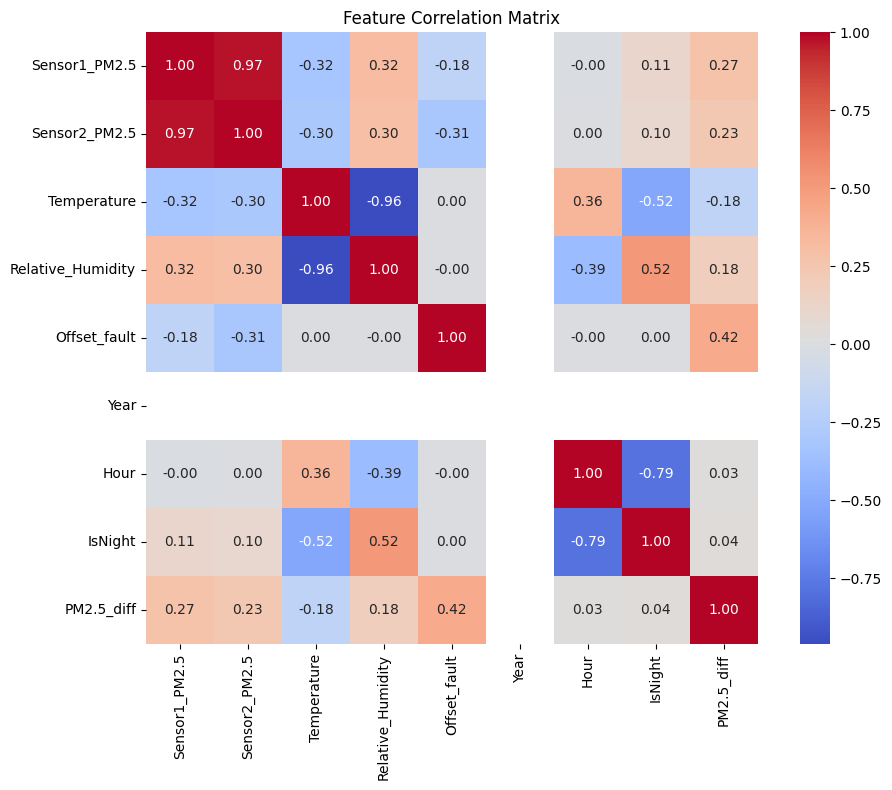

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = train_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# Modeling

In [20]:
# 1) Install if needed (uncomment if you get ModuleNotFoundError)
# !pip install -q lightgbm

# 2) Import
from lightgbm import LGBMClassifier

# 3) Define your model (your params kept as-is)
lgbm = LGBMClassifier(
    objective='binary',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    is_unbalance=True,   # or: class_weight='balanced'
    random_state=42,
    n_jobs=-1
)

# 4) Fit (example)
# lgbm.fit(X_train, y_train)
# preds = lgbm.predict_proba(X_valid)[:, 1]
# preds_label = (preds >= 0.5).astype(int)

In [21]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score
import numpy as np
from tqdm.auto import tqdm

# Features and target — KEEP DataFrames, NOT .values
X = train_df.drop('Offset_fault', axis=1)
y = train_df['Offset_fault']
test_X = test_df  # test_df must have same columns as X

# Time-based CV
tscv = TimeSeriesSplit(n_splits=5)

oof_preds = np.zeros_like(y)
test_preds = np.zeros((test_X.shape[0], tscv.n_splits))

for fold, (train_index, val_index) in enumerate(tqdm(tscv.split(X), total=tscv.n_splits, desc="TimeSeries CV")):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Fresh model each fold
    model = lgbm.__class__(**lgbm.get_params())
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    oof_preds[val_index] = y_pred

    test_pred = model.predict(test_X)
    test_preds[:, fold] = test_pred

# Final metrics
final_f1 = f1_score(y, oof_preds)
print("OOF F1 score:", final_f1)

# Final prediction
final_test_pred = (test_preds.mean(axis=1) > 0.5).astype(int)

TimeSeries CV:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 8564, number of negative: 15029
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 23593, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.362989 -> initscore=-0.562414
[LightGBM] [Info] Start training from score -0.562414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

## Let's train on full data then submit

In [22]:
X = train_df.drop('Offset_fault',axis=1)
y = train_df['Offset_fault']

In [23]:
lgbm.fit(X,y)
FinalPred = lgbm.predict(test_df)

[LightGBM] [Info] Number of positive: 52116, number of negative: 89422
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1007
[LightGBM] [Info] Number of data points in the train set: 141538, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368212 -> initscore=-0.539895
[LightGBM] [Info] Start training from score -0.539895


In [214]:
submission = pd.DataFrame({"ID": ID ,"Offset_Fault": FinalPred})
submission.to_csv('submission.csv',index=False)